In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

In [6]:
# #Ignore if you're not running on colab
# from google.colab import drive
# drive.mount('/content/drive')

# !cd /content/drive/MyDrive/PhD/MassSpecProject #Change this path for your own computer

#Generating Synthetic Scores



In [7]:
def syntheticScores(n, dist='normal', loc=0, scale=1, shape=None):
  assert scale > 0
  if dist == 'normal':
    return np.random.normal(loc, scale, size=n)

  if dist == 'gamma':
    #remember Exponential is a special case of Gamma where shape=1
    assert shape is not None and shape > 0
    return np.random.gamma(shape, scale, size=n)

  if dist == 'gumbel':
    return np.random.gumbel(loc, scale, size=n)

  if dist == 'skew-normal':
    return skewnorm.rvs(shape, loc=loc, scale=scale, size=n)

  else:
    print("Distribution not implemented")

In [9]:
# correct = syntheticScores(5000, dist='skew-normal', loc=30, scale=5, shape=-2)
# incorrect = syntheticScores(5000, dist='skew-normal', loc=20, scale=5, shape=2)
# plt.hist(correct, bins=50, alpha=0.7, color='blue')
# plt.hist(incorrect, bins=50, alpha=0.7, color='red')
# plt.show()

##Mixture of Scores
Let's assume:
$$C \sim SN(\theta_c), \; I_1 \sim SN(\theta_1), \; I_2 \sim SN(\theta_2)$$
where $C$ represents the distribution of scores for the correct PSM, and $I_1, I_2$ represent the first and second highest incorrect scores.

The 1SMix model models *the highest returned score* as a mixture of correct and incorrect scores:
$$S_1 \sim \alpha SN(\theta_c) + (1 - \alpha) SN(\theta_1)$$

The 2SMix model model generalizes this by modeling *the top two returned scores*:
$$S_1 \sim \alpha SN(\theta_c) + (1 - \alpha) SN(\theta_1)$$
$$S_2 \sim \alpha SN(\theta_1) + (1 - \alpha - \beta) SN(\theta_2) + \beta SN (\theta_c)$$

In [10]:
# both = np.stack([correct, incorrect])
# top_score = np.max(both, axis=0)
# bottom_score = np.min(both, axis=0)
# plt.hist(top_score, bins=50, alpha=0.7, color='blue')
# plt.hist(bottom_score, bins=50, alpha=0.7, color='red')
# plt.show()

In [64]:
'''
Function Parameters:
  n--number of samples
  dist--the type of distribution to model the scores (assume all the same for now)

  The rest of these are all lists of length 2 for OneSMix and 3 for TwoSMix:
      loc -- the means of each of the distributions (not needed for gamma)
      scale -- controls variance of each distribution
      shape -- controls the shape of the distribution (skew-normal and gamma only)

The function returns:
    firstScore -- an array containing the highest score
    firstScoreLabels -- an array containing 0s and 1s (and 2s for 2SMix),
                        indicating if the firstScore came from the correct,
                        first incorrect, or second incorrect score
    secondScore -- an array containing the second highest scores
    secondScoreLabels -- an array containing 0s and 1s (and 2s for 2SMix),
                        indicating if the secondScore came from the correct,
                        first incorrect, or second incorrect score
'''

# def OneSMix(n, dist='normal', loc=np.zeros(2), scale=np.ones(2), shape=np.ones(2)):

#   correct = syntheticScores(n, dist, loc[0], scale[0], shape[0])
#   incorrect = syntheticScores(n, dist, loc[1], scale[1], shape[1])

#   both = np.stack([correct, incorrect])
#   firstScore = np.max(both, axis=0)
#   firstScoreLabels = np.argmax(both, axis=0)
#   secondScore = np.min(both, axis=0)
#   return firstScore, firstScoreLabels, secondScore

def TwoSMix(n, dist='normal', alpha=0.5, beta=0.1, loc=np.zeros(3), scale=np.ones(3), shape=np.ones(3)):

    S_1 = []
    S_1_labels = []
    S_2 = []
    S_2_labels = []
    for i in range(n):
        rand = np.random.rand()
        if rand < alpha:
            # generate from theta_correct
            score = syntheticScores(1, dist, loc[0], scale[0], shape[0])[0]
            # S_1.append(score)
            # S_1_labels.append('c')

            # generate from theta_first_incorrect
            score_2 = 999
            while score_2 > score:
                score += .01
                score_2 = syntheticScores(1, dist, loc[1], scale[1], shape[1])[0]
                
            S_1.append(score)
            S_1_labels.append('c')
            
            S_2.append(score_2)
            S_2_labels.append('i1')
            
        else:
            # generate from theta_first_incorrect
            score = syntheticScores(1, dist, loc[1], scale[1], shape[1])[0]
            # S_1.append(score)
            # S_1_labels.append('i1')

            if 1 - rand < 1 - alpha - beta:
                # generate from theta_second_incorrect
                score_2 = 999
                while score_2 > score:
                    score += .01
                    score_2 = syntheticScores(n, dist, loc[2], scale[2], shape[2])[0]
                S_2.append(score_2)
                S_2_labels.append('i2')
            else:
                # generate from theta_correct
                score_2 = 999
                while score_2 > score:
                    score += .01
                    score_2 = syntheticScores(1, dist, loc[0], scale[0], shape[0])[0]
                S_2.append(score_2)
                S_2_labels.append('c')
            
            S_1.append(score)
            S_1_labels.append('i1')

    return np.array(S_1), np.array(S_2), np.array(S_1_labels), np.array(S_2_labels)
    
        
    # correct = syntheticScores(n, dist, loc[0], scale[0], shape[0])
    # incorrect1 = syntheticScores(n, dist, loc[1], scale[1], shape[1])
    # incorrect2 = syntheticScores(n, dist, loc[2], scale[2], shape[2])
    
    # together = np.stack([correct, incorrect1, incorrect2])
    # firstScore = np.max(together, axis=0)
    # firstScoreLabels = np.argmax(together, axis=0)
    
    # #why doesn't numpy have topk SMH
    # ind = np.argpartition(together, -2, axis=0)[-2:]
    # ind = ind[0]
    # secondScore = []
    # for i in range(n):
    # secondScore.append(together[ind[i], i])
    
    # return firstScore, firstScoreLabels, np.array(secondScore), np.array(ind)

In [57]:
dist = 'skew-normal'
alpha = 0.7
beta = 0.2
loc = [36, 20, 18]
scale = [5, 5, 5]
shape = [-5, 5, 5]
# firstScore, firstScoreLabels, secondScore, secondScoreLabels = TwoSMix(10000, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
S_1,S_2,S_1_labels,S_2_labels = TwoSMix(10000, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)


print(np.mean(S_1), np.mean(S_2))
print(len(S_1),len(S_1_labels))
# print(np.count_nonzero(firstScoreLabels))

29.60263441426357 23.00559742588062
10000 10000


(array([  2.,   2.,   2.,   2.,   5.,   2.,   4.,   7.,  13.,  34.,  54.,
         85., 118., 165., 275., 325., 463., 544., 620., 666., 683., 625.,
        591., 600., 538., 450., 425., 402., 374., 329., 272., 240., 204.,
        167., 152., 132.,  83.,  83.,  66.,  45.,  34.,  36.,  27.,  18.,
         11.,  11.,   4.,   3.,   6.,   1.]),
 array([12.38460751, 12.83932752, 13.29404753, 13.74876754, 14.20348755,
        14.65820756, 15.11292757, 15.56764758, 16.0223676 , 16.47708761,
        16.93180762, 17.38652763, 17.84124764, 18.29596765, 18.75068766,
        19.20540767, 19.66012768, 20.11484769, 20.5695677 , 21.02428771,
        21.47900772, 21.93372773, 22.38844774, 22.84316775, 23.29788776,
        23.75260778, 24.20732779, 24.6620478 , 25.11676781, 25.57148782,
        26.02620783, 26.48092784, 26.93564785, 27.39036786, 27.84508787,
        28.29980788, 28.75452789, 29.2092479 , 29.66396791, 30.11868792,
        30.57340793, 31.02812795, 31.48284796, 31.93756797, 32.39228798,
 

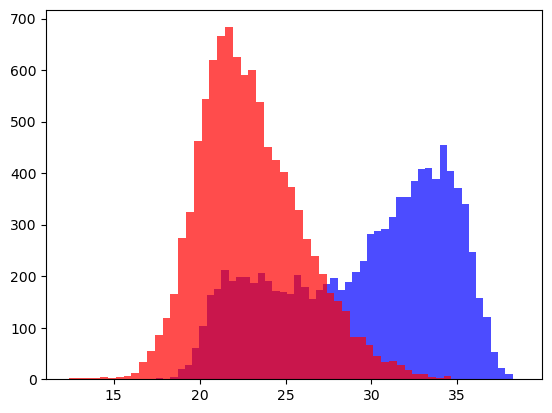

In [58]:
plt.hist(S_1, bins=50, alpha=0.7, color='blue')
plt.hist(S_2, bins=50, alpha=0.7, color='red')

(array([  2.,   0.,   3.,   9.,  15.,  40.,  53., 108., 154., 154., 182.,
        165., 168., 168., 157., 160., 158., 141., 126., 112., 108., 117.,
        114.,  80.,  60.,  74.,  55.,  56.,  43.,  26.,  29.,  35.,  30.,
         23.,  17.,  15.,  12.,  14.,  16.,   6.,   3.,   5.,   3.,   5.,
          6.,   0.,   0.,   1.,   3.,   1.]),
 array([17.44265196, 17.82499797, 18.20734398, 18.58969   , 18.97203601,
        19.35438202, 19.73672803, 20.11907404, 20.50142005, 20.88376607,
        21.26611208, 21.64845809, 22.0308041 , 22.41315011, 22.79549612,
        23.17784214, 23.56018815, 23.94253416, 24.32488017, 24.70722618,
        25.08957219, 25.47191821, 25.85426422, 26.23661023, 26.61895624,
        27.00130225, 27.38364826, 27.76599428, 28.14834029, 28.5306863 ,
        28.91303231, 29.29537832, 29.67772433, 30.06007035, 30.44241636,
        30.82476237, 31.20710838, 31.58945439, 31.9718004 , 32.35414642,
        32.73649243, 33.11883844, 33.50118445, 33.88353046, 34.26587647,
 

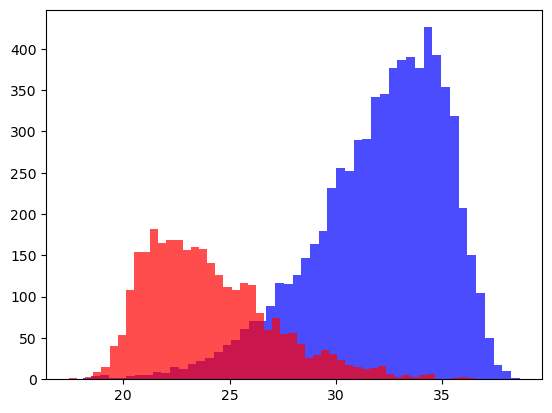

In [59]:
plt.hist(S_1[S_1_labels=='c'], bins=50, alpha=0.7, color='blue')
plt.hist(S_1[S_1_labels=='i1'], bins=50, alpha=0.7, color='red')

(array([ 2.,  1.,  2.,  3., 13., 11., 20., 23., 33., 34., 39., 54., 72.,
        61., 66., 68., 64., 42., 60., 45., 47., 33., 38., 31., 28., 24.,
        22., 15., 11., 18.,  9.,  9.,  4.,  8.,  4.,  6.,  5.,  5.,  2.,
         1.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([15.38228071, 15.66506554, 15.94785037, 16.2306352 , 16.51342002,
        16.79620485, 17.07898968, 17.36177451, 17.64455933, 17.92734416,
        18.21012899, 18.49291382, 18.77569864, 19.05848347, 19.3412683 ,
        19.62405313, 19.90683796, 20.18962278, 20.47240761, 20.75519244,
        21.03797727, 21.32076209, 21.60354692, 21.88633175, 22.16911658,
        22.45190141, 22.73468623, 23.01747106, 23.30025589, 23.58304072,
        23.86582554, 24.14861037, 24.4313952 , 24.71418003, 24.99696485,
        25.27974968, 25.56253451, 25.84531934, 26.12810417, 26.41088899,
        26.69367382, 26.97645865, 27.25924348, 27.5420283 , 27.82481313,
        28.10759796, 28.39038279, 28.67316762, 28.95595244,

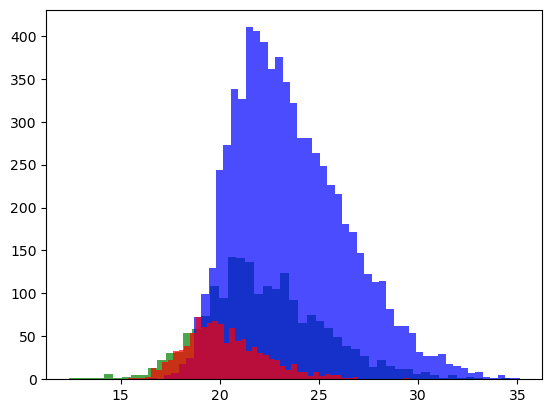

In [60]:
plt.hist(S_2[S_2_labels=='c'], bins=50, alpha=0.7, color='green')
plt.hist(S_2[S_2_labels=='i1'], bins=50, alpha=0.7, color='blue')
plt.hist(S_2[S_2_labels=='i2'], bins=50, alpha=0.7, color='red')

##Replicating the case of GraphNovo (Ignore for Now)

In [29]:
# def graphNovoProxy(n, scale1, scale2):
#   #constructed specifically to replicate GraphNovo Score Distributions using two exponential distributions
#   incorrect = np.random.gamma(1, scale2, size=n//2)
#   correct = 100 * np.ones(n//2) - np.random.gamma(1, scale1, size=n//2)
#   return correct, incorrect

In [30]:
# correct, incorrect = graphNovoProxy(10000, 15, 30)
# bins=[i for i in range(101)]
# plt.hist(correct, bins=bins, alpha=0.7, color='blue')
# plt.hist(incorrect, bins=bins, alpha=0.7, color='red')
# plt.xlim(0, 100)
# plt.show()

##Exporting Scores as TXT files

In [65]:
def exportScores(firstScores, secondScores, firstScoreLabels, secondScoreLabels, path='./', filename='output.txt', write=True):
  n = len(firstScores)
  assert len(secondScores) == n

  s = ''
  for i in range(n):
    first_line = '>> 0 ' + str(i) + ' ABCDEFG/69 \n'
    second_line = '#Index  RnkScr  PnvScr  N-Gap   C-Gap   [M+H]   Charge  Sequence \n'

    d = {'c':'ABCDEFG', 'i1':'CurryWashed', 'i2':'DWhiteMVP'}
    s1, s2 = d[firstScoreLabels[i]], d[secondScoreLabels[i]]


    third_line = '0   ' + str(firstScores[i]) + '   -1   -1   -1   -1   -1   ' + s1 + '\n'
    fourth_line = '1   ' + str(secondScores[i]) + '   -1   -1   -1   -1   -1   ' + s2 + '\n'
    s += (first_line + second_line + third_line + fourth_line + '\n')

  if write:
    # path = '/content/drive/MyDrive/PhD/MassSpecProject/'
    with open(path+filename, 'w') as file:
      file.write(s)
  else:
    print(s)


In [62]:
dist = 'skew-normal'
loc = [30, 20, 18]
scale = [5, 5, 5]
shape = [-5, 5, 5]
S_1, S_2, S_1_labels, S_2_labels = TwoSMix(10000, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
exportScores(S_1, S_2, S_1_labels, S_2_labels, write=False)

>> 0 0 ABCDEFG/69 
#Index  RnkScr  PnvScr  N-Gap   C-Gap   [M+H]   Charge  Sequence 
0   29.169834278004284   -1   -1   -1   -1   -1   ABCDEFG
1   22.521136567666687   -1   -1   -1   -1   -1   CurryWashed

>> 0 1 ABCDEFG/69 
#Index  RnkScr  PnvScr  N-Gap   C-Gap   [M+H]   Charge  Sequence 
0   22.694857802160872   -1   -1   -1   -1   -1   ABCDEFG
1   21.547649335062456   -1   -1   -1   -1   -1   CurryWashed

>> 0 2 ABCDEFG/69 
#Index  RnkScr  PnvScr  N-Gap   C-Gap   [M+H]   Charge  Sequence 
0   26.742138217922413   -1   -1   -1   -1   -1   ABCDEFG
1   20.952455641523407   -1   -1   -1   -1   -1   CurryWashed

>> 0 3 ABCDEFG/69 
#Index  RnkScr  PnvScr  N-Gap   C-Gap   [M+H]   Charge  Sequence 
0   24.13245282154464   -1   -1   -1   -1   -1   ABCDEFG
1   24.057947229403975   -1   -1   -1   -1   -1   CurryWashed

>> 0 4 ABCDEFG/69 
#Index  RnkScr  PnvScr  N-Gap   C-Gap   [M+H]   Charge  Sequence 
0   25.34021843099993   -1   -1   -1   -1   -1   ABCDEFG
1   23.41213496350605   -1   -1   -

In [66]:
for i in range(1, 31):
  filename = 'synthetic_' + str(i) + '.txt'

  n = 10000
  dist = 'skew-normal'

  if i <= 10:
      alpha,beta = 0.7,0.2
      loc = [26+ 2*i, 20, 18]
      scale = [5, 5, 5]
      shape = [-5, 5, 5]
      S_1, S_2, S_1_labels, S_2_labels = TwoSMix(n, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
      exportScores(S_1, S_2, S_1_labels, S_2_labels, filename=filename, write=True)
  elif i <= 20:
      alpha,beta = (i-10)*0.09, 0.09
      loc = [42, 20, 18]
      scale = [5, 5, 5]
      shape = [-5, 5, 5]
      S_1, S_2, S_1_labels, S_2_labels = TwoSMix(n, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
      exportScores(S_1, S_2, S_1_labels, S_2_labels, filename=filename, write=True)
  elif i <= 30:
      alpha,beta = 0.5, (i-20)*.045
      loc = [42, 20, 18]
      scale = [5, 5, 5]
      shape = [-5, 5, 5]
      S_1, S_2, S_1_labels, S_2_labels = TwoSMix(n, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
      exportScores(S_1, S_2, S_1_labels, S_2_labels, filename=filename, write=True)
  # firstScore, firstScoreLabels, secondScore, secondScoreLabels = TwoSMix(n, dist=dist, loc=loc, scale=scale, shape=shape)

  print(filename)
  # print('Alpha: ', 1 - (np.count_nonzero(firstScoreLabels) / n))
  # print('Beta: ', 1 - (np.count_nonzero(secondScoreLabels) / n), '\n')


  # exportScores(firstScore, secondScore, firstScoreLabels, secondScoreLabels, filename=filename, write=True)

synthetic_1.txt
synthetic_2.txt
synthetic_3.txt
synthetic_4.txt
synthetic_5.txt
synthetic_6.txt
synthetic_7.txt
synthetic_8.txt
synthetic_9.txt
synthetic_10.txt
synthetic_11.txt
synthetic_12.txt
synthetic_13.txt
synthetic_14.txt
synthetic_15.txt
synthetic_16.txt
synthetic_17.txt
synthetic_18.txt
synthetic_19.txt
synthetic_20.txt
synthetic_21.txt
synthetic_22.txt
synthetic_23.txt
synthetic_24.txt
synthetic_25.txt
synthetic_26.txt
synthetic_27.txt
synthetic_28.txt
synthetic_29.txt
synthetic_30.txt


# Implementing the Mixture Model

I want to:
*   Implement Shantanu's EM update rules
*   Possibly derive my own update rules for different distriubtions



# Testing on Synthetic Data
Here I want to evaluate a couple things about the mixture model:
*   Given the thresholds the algorithm estimates for a 1% FDR rate, what is the "true" FDR for the data it was fitted to?
*   How stable are



In [76]:
print('index\talpha\tbeta\tloc\tscale\tshape')

def print_tsv(i,alpha,beta,loc,scale,shape):
  print(i,f'{alpha:.2f}',f'{beta:.2f}',f'{loc[0]},{loc[1]},{loc[2]}',f'{scale[0]},{scale[1]},{scale[2]}',f'{shape[0]},{shape[1]},{shape[2]}',sep='\t')

for i in range(1, 31):
  filename = 'synthetic_' + str(i) + '.txt'

  n = 10000
  dist = 'skew-normal'

  if i <= 10:
      alpha,beta = 0.7,0.2
      loc = [26+ 2*i, 20, 18]
      scale = [5, 5, 5]
      shape = [-5, 5, 5]
      # S_1, S_2, S_1_labels, S_2_labels = TwoSMix(n, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
      # exportScores(S_1, S_2, S_1_labels, S_2_labels, filename=filename, write=True)
  elif i <= 20:
      alpha,beta = (i-10)*0.09, 0.09
      loc = [42, 20, 18]
      scale = [5, 5, 5]
      shape = [-5, 5, 5]
      # S_1, S_2, S_1_labels, S_2_labels = TwoSMix(n, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
      # exportScores(S_1, S_2, S_1_labels, S_2_labels, filename=filename, write=True)
  elif i <= 30:
      alpha,beta = 0.5, (i-20)*.045
      loc = [42, 20, 18]
      scale = [5, 5, 5]
      shape = [-5, 5, 5]
  print_tsv(i,alpha,beta,loc,scale,shape)
      # S_1, S_2, S_1_labels, S_2_labels = TwoSMix(n, alpha=alpha, beta=beta, dist=dist, loc=loc, scale=scale, shape=shape)
      # exportScores(S_1, S_2, S_1_labels, S_2_labels, filename=filename, write=True)
  # firstScore, firstScoreLabels, secondScore, secondScoreLabels = TwoSMix(n, dist=dist, loc=loc, scale=scale, s

index	alpha	beta	loc	scale	shape
1	0.70	0.20	28,20,18	5,5,5	-5,5,5
2	0.70	0.20	30,20,18	5,5,5	-5,5,5
3	0.70	0.20	32,20,18	5,5,5	-5,5,5
4	0.70	0.20	34,20,18	5,5,5	-5,5,5
5	0.70	0.20	36,20,18	5,5,5	-5,5,5
6	0.70	0.20	38,20,18	5,5,5	-5,5,5
7	0.70	0.20	40,20,18	5,5,5	-5,5,5
8	0.70	0.20	42,20,18	5,5,5	-5,5,5
9	0.70	0.20	44,20,18	5,5,5	-5,5,5
10	0.70	0.20	46,20,18	5,5,5	-5,5,5
11	0.09	0.09	42,20,18	5,5,5	-5,5,5
12	0.18	0.09	42,20,18	5,5,5	-5,5,5
13	0.27	0.09	42,20,18	5,5,5	-5,5,5
14	0.36	0.09	42,20,18	5,5,5	-5,5,5
15	0.45	0.09	42,20,18	5,5,5	-5,5,5
16	0.54	0.09	42,20,18	5,5,5	-5,5,5
17	0.63	0.09	42,20,18	5,5,5	-5,5,5
18	0.72	0.09	42,20,18	5,5,5	-5,5,5
19	0.81	0.09	42,20,18	5,5,5	-5,5,5
20	0.90	0.09	42,20,18	5,5,5	-5,5,5
21	0.50	0.04	42,20,18	5,5,5	-5,5,5
22	0.50	0.09	42,20,18	5,5,5	-5,5,5
23	0.50	0.14	42,20,18	5,5,5	-5,5,5
24	0.50	0.18	42,20,18	5,5,5	-5,5,5
25	0.50	0.22	42,20,18	5,5,5	-5,5,5
26	0.50	0.27	42,20,18	5,5,5	-5,5,5
27	0.50	0.32	42,20,18	5,5,5	-5,5,5
28	0.50	0.36	42,20,18	5,5,5	-5,